In [1]:

from pybaseball import  playerid_lookup
from pybaseball import  statcast_pitcher
from pybaseball import  statcast
import pandas as pd
import numpy as np

lr_results = []
rf_results = []
xgb_results = []
knn_results = []
nn_results = []


pitchers = [
    "Logan Gilbert",
    "Seth Lugo",
    "Logan Webb",
    "Zack Wheeler",
    "Aaron Nola",
    "Corbin Burnes",
    "José Berríos",
    "Tarik Skubal",
    "George Kirby",
    "Dylan Cease",
    "Jake Irvin",
    "Luis Severino",
    "Sean Manaea",
    "Brandon Pfaadt",
    "Cristopher Sánchez",
    "Mitch Keller",
    "Tanner Houck",
    "Bailey Ober",
    "Patrick Corbin",
    "MacKenzie Gore",
    "Blake Snell",
    "Justin Steele",
    "Brady Singer",
    "Freddy Peralta",
    "Michael Pineda"
]


def separate_names(full_name):
    parts = full_name.split()
    first_name = " ".join(parts[:-1])
    last_name = parts[-1]
    return first_name, last_name

pitcher_ids = []

for i in pitchers:
    a = playerid_lookup(separate_names(i)[1], separate_names(i)[0])
    
    id = a['key_mlbam'].values
    pitcher_ids.append(id.item())
    
print(pitcher_ids)
    

# for i in statcast method:
    
#     get id's for each pitcher
    
#     add to list
    
# results = []

# for i in pitchers:

#     pull their one year data 
    
#     add to df 
    
#     run through model of choice 
    
#     get f1 score and accuracy
    
    
    
    


Gathering player lookup table. This may take a moment.
[669302, 607625, 657277, 554430, 605400, 669203, 621244, 669373, 669923, 656302, 663623, 622663, 640455, 694297, 650911, 656605, 656557, 641927, 571578, 669022, 605483, 657006, 663903, 642547, 501381]


In [74]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from sklearn.model_selection import train_test_split, cross_val_score
from pybaseball import  statcast_pitcher
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
# Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report,
)
from src.data_transformation.preprocess import pull_pitcher_data

    
def validate(first_name, last_name, start_date, end_date):
    
    df = pull_pitcher_data(first_name, last_name, start_date, end_date) 
    
    final_features = ['at_bat_number','pitch_type_map', 'balls', 'strikes', 'outs_when_up',
       'bat_score', 'prev_pitch_1', 'prev_pitch_2', 'prev_pitch_3',
       'batter_is_right', 
       ]
    df = df[final_features]
    df = df.dropna()
    #create target and feature
    X = df.drop(columns=["pitch_type_map"])
    y = df["pitch_type_map"]

    #resample for class imbalance
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)


    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.35, random_state=42)
    class_mapping = {0: ' Fastball',
                    1: 'Sinker',
                    2: 'Cutter',
                    3: 'Curveball',
                    4: 'Slider',
                    5: 'Changeup',
                    6: 'Knuckle'}

    label_encoder = LabelEncoder()

    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)    
    
    #results dict
    results = {}
    
    #logistic Regression:
    lr_model = LogisticRegression(random_state=43, max_iter=10000)
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    y_pred_prob = lr_model.predict_proba(X_test)
    results['LogisticRegression'] = {
        'accuracy': accuracy_score(y_test, lr_predictions),
        'f1': f1_score(y_test, lr_predictions, average='weighted')
    }
    
    #KNN
    knn_model = KNeighborsClassifier(n_neighbors= 26)
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    results['KNN'] = {
        'accuracy': accuracy_score(y_test, knn_predictions),
        'f1': f1_score(y_test, knn_predictions, average='weighted')
    }
    
    #RF
    rf_model = RandomForestClassifier(bootstrap=True, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    results['RF'] = {
        'accuracy': accuracy_score(y_test, rf_predictions),
        'f1': f1_score(y_test, rf_predictions, average='weighted')
    }
    
    #XGB
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=45)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    results['XGB'] = {
        'accuracy': accuracy_score(y_test, xgb_predictions),
        'f1': f1_score(y_test, xgb_predictions, average='weighted')
    }
    
    return results
    
    


In [76]:
import pandas as pd

pitcher_tuples = [tuple(name.split()) for name in pitchers]

all_results = []

for first, last in pitcher_tuples:
    try:
        model_scores = validate(first, last, start, end)
        for model_name, scores in model_scores.items():
            all_results.append({
                'pitcher': f"{first} {last}",
                'model': model_name,
                'accuracy': scores['accuracy'],
                'f1': scores['f1']
            })
    except Exception as e:
        print(f"Failed for {first} {last}: {e}")


Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Failed for Corbin Burnes: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3
Gathering Player Data
Gathering Player Data
Gathering Player Data
Failed for George Kirby: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 1, n_samples = 1
Gathering Player Data
Failed for Dylan Cease: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Failed for Cristopher Sánchez: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3
Gathering Player Data
Gathering Player Data
Failed for Tanner Houck: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 1, n_samples = 1
Gathering Player Data
Gatherin

In [77]:
results_df = pd.DataFrame(all_results)
results_df.groupby('model').agg({'accuracy': 'mean', 'f1': 'mean'})
# results_df.sort_values('model')

,accuracy,f1
model,,
KNN,0.441521,0.403550
LogisticRegression,0.425247,0.400966
RF,0.643295,0.635933
XGB,0.641084,0.637370


In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, f1_score, make_scorer
# from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
# from sklearn.metrics import make_scorer
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from src.data_transformation.preprocess import pull_pitcher_data

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def validate3(first_name, last_name, start_date, end_date):
    df = pull_pitcher_data(first_name, last_name, start_date, end_date) 
    
    final_features = ['at_bat_number','pitch_type_map', 'balls', 'strikes', 'outs_when_up',
       'bat_score', 'prev_pitch_1', 'prev_pitch_2', 'prev_pitch_3',
       'batter_is_right', 
       ]
    df = df[final_features]
    df = df.dropna()
    #prop_columns = [col for col in df.columns if col.startswith('prop')]
    
    #+ prop_columns
    # this is dropping any NA rows, or 0 rows
    

    X = df.drop(columns=["pitch_type_map"])
    y = df["pitch_type_map"]

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.classes_

    class_mapping = {
        0: 'Fastball',
        1: 'Sinker',
        2: 'Cutter',
        3: 'Curveball',
        4: 'Slider',
        5: 'Changeup',
        6: 'Knuckle'
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=500, max_features='sqrt', bootstrap=True, random_state=42)
    # resampler = SMOTETomek(random_state=42, smote=SMOTE(k_neighbors=k_neighbors))
    # pipe = ImbPipeline([
    #     ('resample', SMOTETomek(random_state=42)),
    #     ('clf', rf_model)
    # ])

    acc_scores = []
    f1_scores = []
    all_y_true = []
    all_y_pred = []

    for train_idx, test_idx in skf.split(X, y_encoded):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y_encoded[train_idx], y_encoded[test_idx]

        # Calculate safe k_neighbors based on smallest class count
        class_counts = pd.Series(y_train_fold).value_counts()
        min_samples = class_counts.min()
        k_neighbors = max(1, min(min_samples - 1, 5))  # Keep k <= samples-1, max 5

        resampler = SMOTETomek(random_state=42, smote=SMOTE(k_neighbors=k_neighbors))

        pipe = ImbPipeline([
            ('resample', resampler),
            ('clf', rf_model)
        ])

        pipe.fit(X_train_fold, y_train_fold)
        y_pred_fold = pipe.predict(X_test_fold)

        acc_scores.append(accuracy_score(y_test_fold, y_pred_fold))
        f1_scores.append(f1_score(y_test_fold, y_pred_fold, average='weighted'))

        all_y_true.extend(y_test_fold)
        all_y_pred.extend(y_pred_fold)

    print(f"\nAverage Accuracy (CV): {np.mean(acc_scores):.4f}")
    print(f"Average F1 Score (Weighted, CV): {np.mean(f1_scores):.4f}")

    # -------------------------------
    # Confusion Matrix & Classification Report
    # -------------------------------
    print("\nClassification Report (Random Forest):\n")
    print(classification_report(all_y_true, all_y_pred, target_names=[class_mapping[c] for c in np.unique(y_encoded)]))

    conf_matrix = confusion_matrix(all_y_true, all_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[class_mapping[c] for c in np.unique(y_encoded)])
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Overall Confusion Matrix (Random Forest - All CV Folds)")
    plt.show()

    # -------------------------------
    # ROC Curve + AUC (Multiclass)
    # -------------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

    pipe.fit(X_train, y_train)
    y_score = pipe.predict_proba(X_test)

    y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
    n_classes = y_test_bin.shape[1]

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_mapping[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve (Random Forest)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # -------------------------------
    # Feature Importance Plot
    # -------------------------------
    final_rf = pipe.named_steps['clf']
    importances = final_rf.feature_importances_
    feature_names = X.columns

    feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feat_df['Feature'], feat_df['Importance'])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance")
    plt.title("Random Forest Feature Importances")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy_cv': np.mean(acc_scores),
        'f1_cv': np.mean(f1_scores)
    }


Gathering Player Data

Average Accuracy (CV): 0.3958
Average F1 Score (Weighted, CV): 0.4005

Classification Report (Random Forest):

              precision    recall  f1-score   support

    Fastball       0.45      0.42      0.44      1022
      Sinker       0.12      0.14      0.13       194
      Cutter       0.49      0.47      0.48      1103
   Curveball       0.22      0.25      0.24       410

    accuracy                           0.40      2729
   macro avg       0.32      0.32      0.32      2729
weighted avg       0.41      0.40      0.40      2729



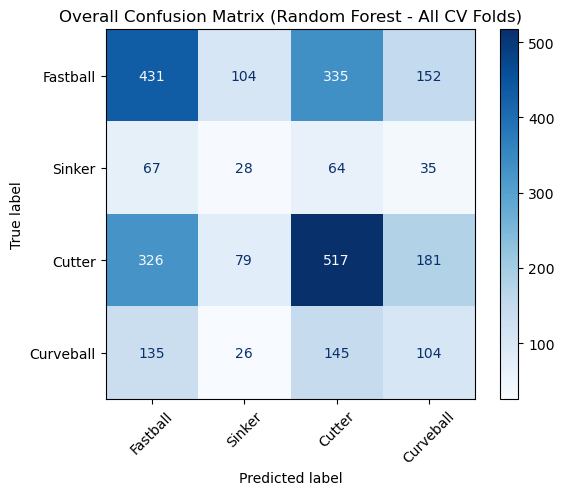

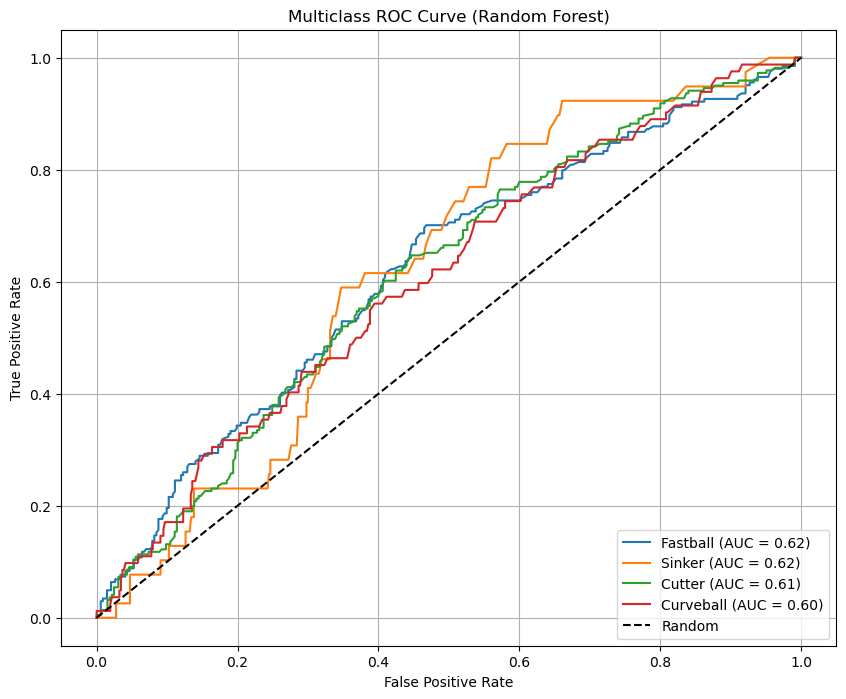

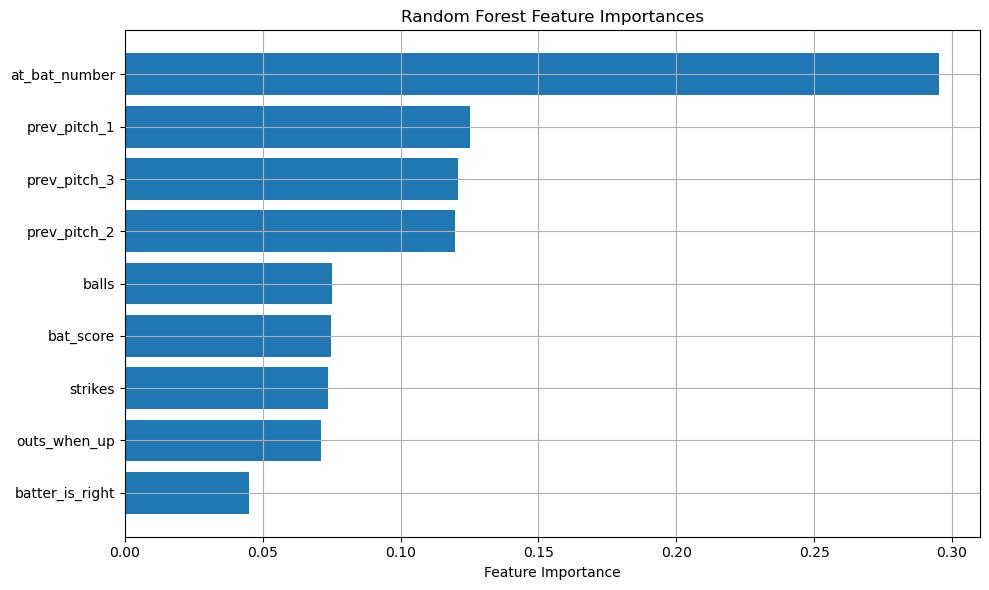

{'accuracy_cv': 0.3957562926370266, 'f1_cv': 0.40045248642824227}

In [72]:
start = '2024-04-01'
end = '2024-10-01'

validate3('chris', 'sale', start, end)